**Problem statement**: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the **International Skin Imaging Collaboration (ISIC)**. All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.

In this assignment, we will build a **multiclass classification model using a custom convolutional neural network in TensorFlow**. 

##### Data Summary:

The data set contains the following diseases:

- Actinic keratosis
- Basal cell carcinoma
- Dermatofibroma
- Melanoma
- Nevus
- Pigmented benign keratosis
- Seborrheic keratosis
- Squamous cell carcinoma
- Vascular lesion


### Importing all the important libraries

In [1]:
# importing all respective libraries
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
%matplotlib inline

2024-07-09 04:46:19.821190: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-09 04:46:19.821351: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-09 04:46:19.954759: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Importing Skin Cancer Data
- Upload the Skin Cancer Data to Google Drive and then utilize google.colab to connect the drive.

In [22]:
# un-comment when running in google colab
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

In [23]:
# un-comment when running in google colab
#data_dir_train = pathlib.Path("/content/drive/MyDrive/upgrad/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
#data_dir_test = pathlib.Path('/content/drive/MyDrive/upgrad/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

- Because of the limitations on Google Colab GPU utilization, Kaggle can be employed as an alternative, as it offers a free usage of 30 hours per week.

In [2]:
# here we are rererring public Skin cancer ISIC The International Skin Imaging Collaboration dataset.
# un-comment when running in kaggle
data_dir_train = pathlib.Path("/kaggle/input/skin-cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/kaggle/input/skin-cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [3]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


- This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

- Out of total 2357 images, 2239 are train images and 118 are test images

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader

In [4]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [5]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  directory=data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [6]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  directory=data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [7]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
- Visualizing few of images

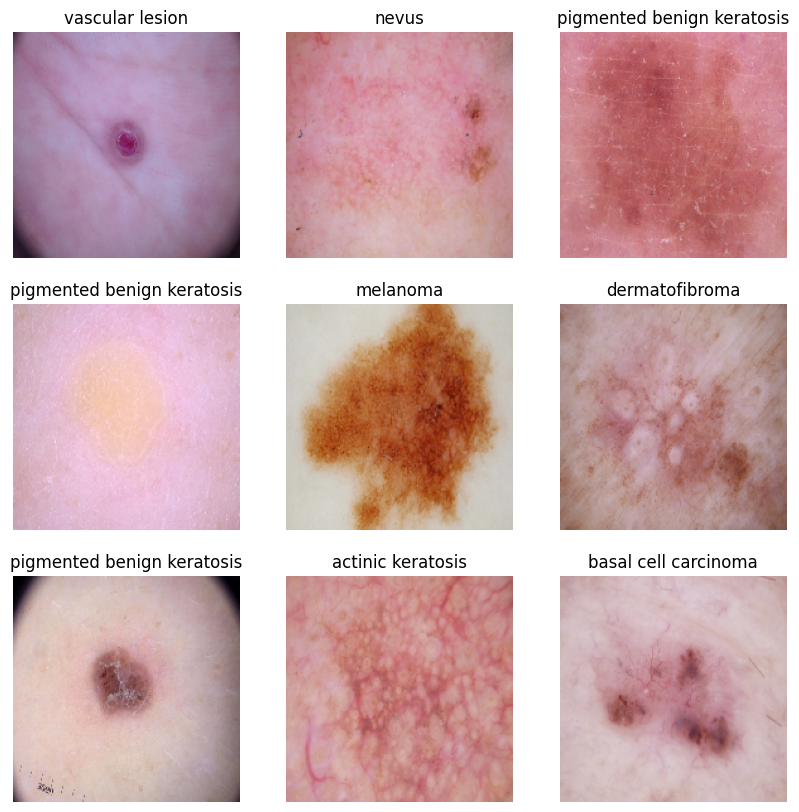

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

- Viewing shape of tensor of train_ds and val_ds

In [9]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Creating the model
- Creating a custom CNN model, which can accurately detect 9 classes present in the dataset.

- Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). 
- The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
img_rows, img_cols = 180, 180
input_shape = (img_rows, img_cols, 3)
num_classes = len(class_names)

model = Sequential()
model.add(layers.Rescaling(1./255, input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3),padding = 'same',activation= 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'same',activation ='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'same',activation ='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'same',activation ='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(16, kernel_size=(7, 7),padding = 'same',activation= 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, kernel_size=(11,11),padding = 'same',activation ='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(256, kernel_size=(3, 3),padding = 'same',activation ='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(9,activation='softmax'))


/opt/conda/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
# print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 22, 22, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 11, 16)     │        50,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 5, 5, 128)      │       247,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 2, 2, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 720,601 (2.75 MB)

 Trainable params: 720,601 (2.75 MB)

 Non-trainable params: 0 (0.00 B)

### Compile the model
Using an appropirate optimiser and loss function for model training 

In [13]:
# compile the model, with choosing an appropirate optimiser and loss function
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)
opt=tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

### Train the model

In [14]:
# fitting the model with 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,callbacks=[learn_control]
)

Epoch 1/20
 3/56 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.0642 - loss: 2.1818  

I0000 00:00:1720500462.882529     116 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 117ms/step - accuracy: 0.1967 - loss: 2.0787 - val_accuracy: 0.2058 - val_loss: 2.0512 - learning_rate: 0.0010
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.1826 - loss: 2.0357 - val_accuracy: 0.2058 - val_loss: 2.0409 - learning_rate: 0.0010
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.2201 - loss: 2.0046 - val_accuracy: 0.2864 - val_loss: 1.9088 - learning_rate: 0.0010
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.2946 - loss: 1.8395 - val_accuracy: 0.2013 - val_loss: 2.0222 - learning_rate: 0.0010
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.3221 - loss: 1.7810 - val_accuracy: 0.3893 - val_loss: 1.6825 - learning_rate: 0.0010
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.3636 - loss: 1.6868 - val_accuracy: 0.3602 - val_loss: 1.6604 - learning_rate: 0.0010
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.3600 - loss: 1.7072 - val_accuracy: 0.

### Visualizing training results

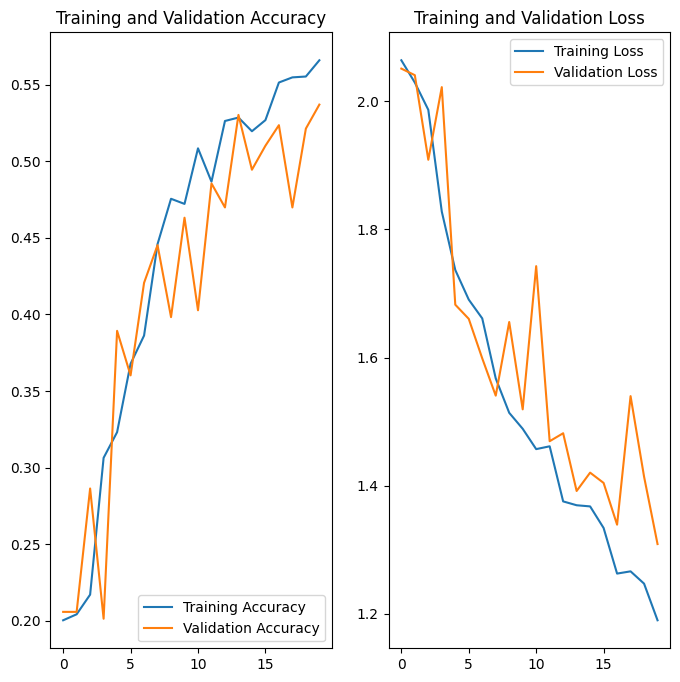

In [15]:
# Visualizing training results by plotting
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5938 - loss: 1.1508
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5656 - loss: 1.2652
Accuracy:  0.5954241156578064
Validation Accuracy:  0.536912739276886
Loss:  1.1416300535202026
Validation Loss 1.308692216873169


#### Write your findings after the model fit, see if there is an evidence of model overfit or underfit

##### Findings
- The Traing accuracy is more that validation accuracy.
- The model is overfitting.
- The model accuracy is low.

In [17]:
# choosing an appropriate data augumentation strategy. 
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical", input_shape= input_shape),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1),
  ]
)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


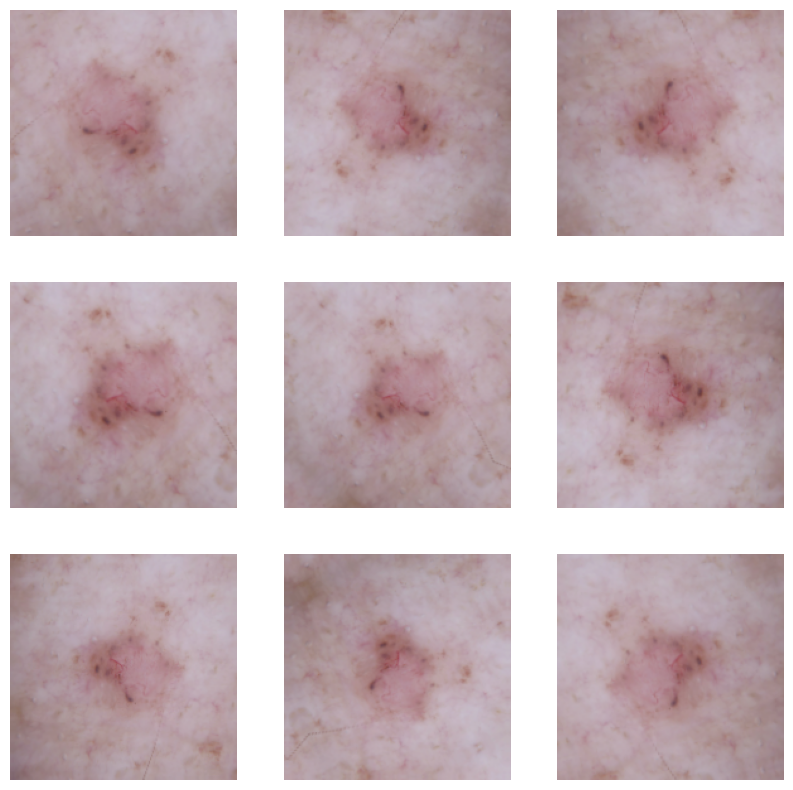

In [18]:
# Visualize how  augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Create, compile and train the model

In [19]:
model = Sequential()

model.add(layers.Rescaling(1./255, input_shape=input_shape))
model.add(data_augmentation)
model.add(Conv2D(32, kernel_size=(3, 3),padding = 'same',activation= 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'same',activation ='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'same',activation ='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'same',activation ='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(16, kernel_size=(7, 7),padding = 'same',activation= 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, kernel_size=(11, 11),padding = 'same',activation ='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(256, kernel_size=(3, 3),padding = 'same',activation ='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(9,activation='softmax'))

### Compiling the model

In [20]:
# Choosing an appropirate optimiser and loss function
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)
opt=tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [21]:
# View the summary of all layers
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 45, 45, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 22, 22, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 11, 11, 16)     │        50,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 5, 5, 128)      │       247,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 2, 2, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         1,16

 Total params: 720,601 (2.75 MB)

 Trainable params: 720,601 (2.75 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [22]:
## Train the model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs, callbacks=[learn_control]
)

Epoch 1/20


2024-07-09 05:06:04.121795: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_2_1/dropout_6_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - accuracy: 0.2041 - loss: 2.0911 - val_accuracy: 0.1924 - val_loss: 2.0781 - learning_rate: 0.0010
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.1759 - loss: 2.0419 - val_accuracy: 0.2058 - val_loss: 2.0272 - learning_rate: 0.0010
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.1859 - loss: 2.0053 - val_accuracy: 0.2058 - val_loss: 2.0227 - learning_rate: 0.0010
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.2204 - loss: 2.0094 - val_accuracy: 0.1924 - val_loss: 2.0331 - learning_rate: 0.0010
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.1794 - loss: 2.0284 - val_accuracy: 0.2058 - val_loss: 2.0326 - learning_rate: 0.0010
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.1892 - loss: 2.0314 - val_accuracy: 0.2058 - val_loss: 2.0287 - learning_rate: 0.0010
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.1984 - loss: 2.0233
Epoch 7: ReduceLROn

### Visualizing the results

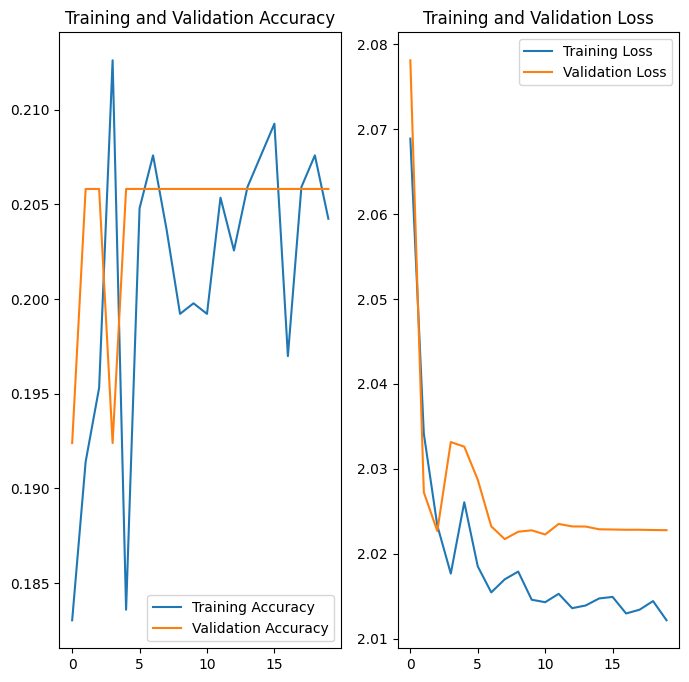

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.2018 - loss: 2.0050
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2069 - loss: 1.9888
Accuracy:  0.2064732164144516
Validation Accuracy:  0.20581655204296112
Loss:  2.012962818145752
Validation Loss 2.022768497467041


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [28]:
## Your code goes here.
# images in each classes
data = []
for i in range(len(class_names)):
  name = class_names[i]
  number = len(list(data_dir_train.glob(f'{class_names[i]}/*.jpg')))
  data.append([name, number])
df = pd.DataFrame(data, columns=['class', 'number'])
df

,class,number
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


<function matplotlib.pyplot.show(close=None, block=None)>

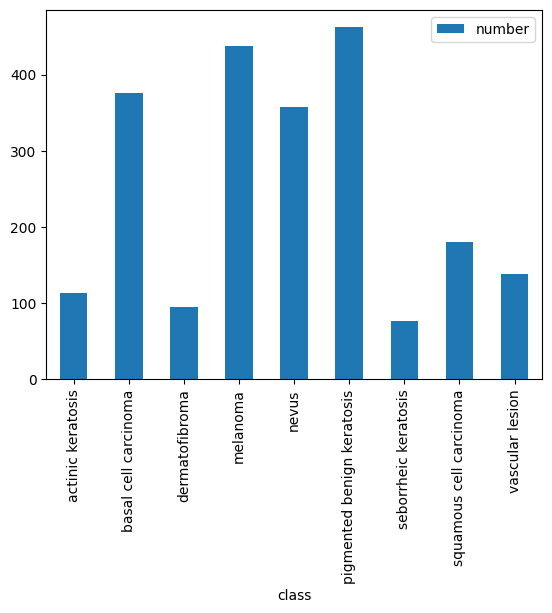

In [29]:
df.plot.bar(x='class',y='number',rot=90)
plt.show

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [30]:
!pip install Augmentor

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [31]:
path_to_training_dataset="/kaggle/input/skin-cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i, output_directory='/kaggle/working/'+i+'/output/')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /kaggle/working/actinic keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D5177A52F50>: 100%|██████████| 500/500 [00:06<00:00, 74.45 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to /kaggle/working/basal cell carcinoma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D52130F9D80>: 100%|██████████| 500/500 [00:06<00:00, 81.79 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to /kaggle/working/dermatofibroma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D52443D3820>: 100%|██████████| 500/500 [00:06<00:00, 80.99 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to /kaggle/working/melanoma/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7D515812AF50>: 100%|██████████| 500/500 [00:32<00:00, 15.42 Samples/s] 


Initialised with 357 image(s) found.
Output directory set to /kaggle/working/nevus/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=767x576 at 0x7D515810DCF0>: 100%|██████████| 500/500 [00:34<00:00, 14.45 Samples/s]  


Initialised with 462 image(s) found.
Output directory set to /kaggle/working/pigmented benign keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D51580F0700>: 100%|██████████| 500/500 [00:05<00:00, 84.81 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to /kaggle/working/seborrheic keratosis/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7D5177F792D0>: 100%|██████████| 500/500 [00:14<00:00, 34.30 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /kaggle/working/squamous cell carcinoma/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7D515812ADD0>: 100%|██████████| 500/500 [00:05<00:00, 84.11 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /kaggle/working/vascular lesion/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D5178D7E500>: 100%|██████████| 500/500 [00:06<00:00, 80.54 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [32]:
out_dir = pathlib.Path("/kaggle/working")
image_count_train = len(list(out_dir.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [33]:
from glob import glob
path_list = [x for x in glob(os.path.join(out_dir, '*','output', '*.jpg'))]
path_list

['/kaggle/working/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026959.jpg_3ace50d2-9271-4ddc-a3ed-f64fb3952d33.jpg',
 '/kaggle/working/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028120.jpg_da30d3a8-b55b-473a-a04e-303f0187d87b.jpg',
 '/kaggle/working/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027454.jpg_2761c80e-46d9-4619-8b66-b5b0775e48d4.jpg',
 '/kaggle/working/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025339.jpg_7fc397aa-0006-4fb1-9a39-e5018c644c1a.jpg',
 '/kaggle/working/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027310.jpg_a3d8d890-f67a-480e-a14f-644adf1ee855.jpg',
 '/kaggle/working/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027954.jpg_5440eb7d-193a-4319-91fc-3ca11e5ab019.jpg',
 '/kaggle/working/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026539.jpg_b27e6a0

In [34]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(out_dir, '*','output', '*.jpg'))]
lesion_list_new

['pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmen

In [35]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [36]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])# new_df = original_df.append(df2)
df2

,Path,Label
0,/kaggle/working/pigmented benign keratosis/out...,pigmented benign keratosis
1,/kaggle/working/pigmented benign keratosis/out...,pigmented benign keratosis
2,/kaggle/working/pigmented benign keratosis/out...,pigmented benign keratosis
3,/kaggle/working/pigmented benign keratosis/out...,pigmented benign keratosis
4,/kaggle/working/pigmented benign keratosis/out...,pigmented benign keratosis
...,...,...
4495,/kaggle/working/squamous cell carcinoma/output...,squamous cell carcinoma
4496,/kaggle/working/squamous cell carcinoma/output...,squamous cell carcinoma
4497,/kaggle/working/squamous cell carcinoma/output...,squamous cell carcinoma
4498,/kaggle/working/squamous cell carcinoma/output...,squamous cell carcinoma


In [37]:
df2['Label'].value_counts()

Label
pigmented benign keratosis    500
seborrheic keratosis          500
melanoma                      500
actinic keratosis             500
dermatofibroma                500
nevus                         500
vascular lesion               500
basal cell carcinoma          500
squamous cell carcinoma       500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [38]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [39]:
#data_dir_train="path to directory with training data + data created using augmentor"
data_dir_train = "/kaggle/working/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 3600 files for training.


#### **Todo:** Create a validation dataset

In [40]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 900 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [53]:
## your code goes here
model = Sequential()
model.add(layers.Rescaling(1./255,input_shape=(180,180,3))) 
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Conv2D(256,kernel_size=(11,11),activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(len(class_names),activation='softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [54]:
## your code goes here
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)
opt=tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [55]:
# View the summary of all layers
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 10, 10, 256)    │     3,965,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │     1,638,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,738,825 (21.89 MB)

 Trainable params: 5,738,825 (21.89 MB)

 Non-trainable params: 0 (0.00 B)

#### **Todo:**  Train your model

In [56]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
              callbacks=[learn_control]
)

Epoch 1/30
  3/113 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.0938 - loss: 2.2433

W0000 00:00:1720496530.584494     134 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.1370 - loss: 2.1698

W0000 00:00:1720496541.088441     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720496541.752922     134 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


113/113 ━━━━━━━━━━━━━━━━━━━━ 20s 110ms/step - accuracy: 0.1373 - loss: 2.1691 - val_accuracy: 0.2289 - val_loss: 1.8152 - learning_rate: 0.0010
Epoch 2/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.2400 - loss: 1.8645 - val_accuracy: 0.3311 - val_loss: 1.7508 - learning_rate: 0.0010
Epoch 3/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.3179 - loss: 1.7134 - val_accuracy: 0.2667 - val_loss: 1.9269 - learning_rate: 0.0010
Epoch 4/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.2953 - loss: 1.7352 - val_accuracy: 0.3844 - val_loss: 1.5495 - learning_rate: 0.0010
Epoch 5/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.3587 - loss: 1.6166 - val_accuracy: 0.4122 - val_loss: 1.4613 - learning_rate: 0.0010
Epoch 6/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.3667 - loss: 1.6167 - val_accuracy: 0.4156 - val_loss: 1.5665 - learning_rate: 0.0010
Epoch 7/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.3953 - loss: 1.4991 - v

#### **Todo:**  Visualize the model results

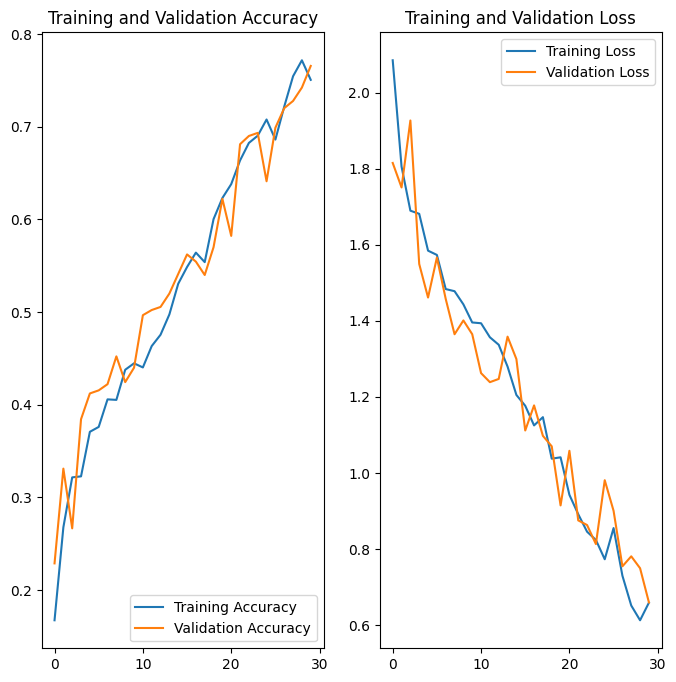

In [57]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



In [58]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.8477 - loss: 0.4506
 3/29 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8056 - loss: 0.4704

W0000 00:00:1720496739.258500     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7729 - loss: 0.5983
Accuracy:  0.8536111116409302
Validation Accuracy:  0.7655555605888367
Loss:  0.4348974823951721
Validation Loss 0.6598337888717651


In [ ]:
#!rm -rf /kaggle/working/*